This script showcases the ability of namaster to compute Gaussian estimates of the covariance matrix. This is currently only supported for spin-0 fields.

In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from __future__ import print_function
from __future__ import division

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Import the NaMaster python wrapper
import pymaster as nmt

In [34]:
# HEALPix map resolution
nside = 256

We start by creating some synthetic masks and maps with contaminants.

Here we will focus on the cross-correlation of a spin-2 and a spin-1 field. 

In [35]:
# Read and apodize mask
mask = nmt.mask_apodization(hp.read_map("../test/mask.fits", verbose=False),
    1.,
    apotype="Smooth")

Let's now create a fictitious theoretical power spectrum to generate Gaussian realizations:

In [36]:
larr = np.arange(3 * nside)
clarr = ((larr + 1.) / 80.)**(-1.1) + 1.

This routine generates a scalar Gaussian random field based on this power spectrum

In [37]:
def get_sample_field():
    mp = hp.synfast(clarr, nside, verbose=False)
    return nmt.NmtField(mask, [mp])

We also copy this function from sample_workspaces.py. It computes power spectra given a pair of fields and a workspace.

In [38]:
def compute_master(f_a, f_b, wsp) :
    cl_coupled=nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled=wsp.decouple_cell(cl_coupled)

    return cl_decoupled

In [39]:
# Let's generate one particular sample and its power spectrum.

# Field
f0 = get_sample_field()
b = nmt.NmtBin(nside, nlb=20) # We will use 20 multipoles per bandpower.

In [40]:
# Workspace
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f0, f0, b)
cl_0=compute_master(f0, f0, w)[0]

In [41]:
# Let's now compute the gaussian estimate of the covariance!
# First we generate a NmtCovarianceWorkspace object to precompute
# and store the necessary coupling coefficients
cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(w, w) #<- This is the time-consuming operation
covar = nmt.gaussian_covariance(cw, clarr, clarr, clarr, clarr)

In [42]:
# Let's now compute the sample covariance
print("Sample covariance")
nsamp = 100
covar_sample=np.zeros([len(cl_0), len(cl_0)])
mean_sample=np.zeros(len(cl_0))
for i in np.arange(nsamp):
    print(i)
    f = get_sample_field()
    cl = compute_master(f, f, w)[0]
    covar_sample += cl[None, :] * cl[:, None]
    mean_sample += cl
mean_sample /= nsamp
covar_sample = covar_sample / nsamp - mean_sample[None, :] * mean_sample[:, None]

Sample covariance
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


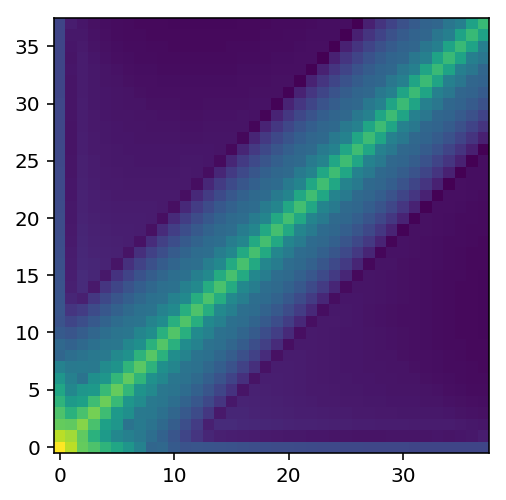

In [43]:
# Let's plot them:
plt.figure()
plt.imshow(np.log10(np.abs(covar)), origin='lower', interpolation='nearest')

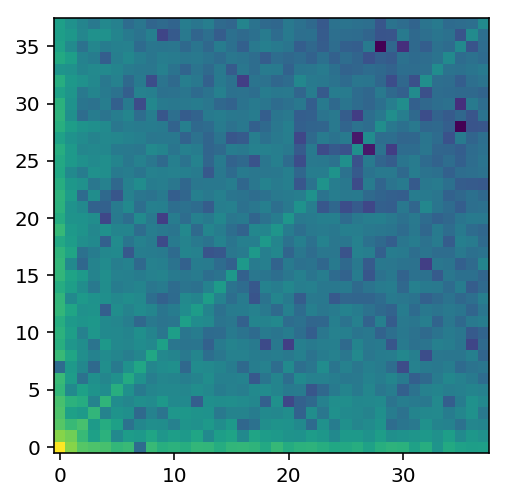

In [44]:
plt.figure()
plt.imshow(np.log10(np.abs(covar_sample)), origin='lower', interpolation='nearest')

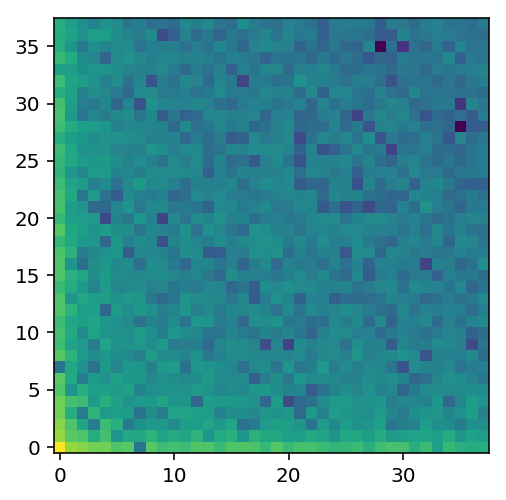

In [45]:
plt.figure()
plt.imshow(np.log10(np.abs(covar-covar_sample)), origin='lower', interpolation='nearest')